# Dataset from Kiva.org - World Poverty and Micro-lending

This dataset is from __[Kiva.org](https://www.kiva.org/)__, a company which allows anyone with an account to donate small amounts of money as microloans to those in underserved areas.  The dataset below was found on __[Kaggle](https://www.kaggle.com/kiva/data-science-for-good-kiva-crowdfunding)__ and was part of a contest encouraging people to use the data in order to find insights on their assessments of poverty levels. This notebook will examine a slightly different aspect, namely the factors which might point to a loan scenario which would have the quickest funding rate (i.e. a loan request which is usually posted on the website for a relatively short amount of time before it receives full funding). This notebook will look at how the current dataset points to current funding rates (namely the time-frame between the first loan request is posted and when it reaches full-funding) and propose an experiment for looking into this further and seeing what might, perhaps, lead to speeding up this funding rate. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import pendulum as pend
%matplotlib inline

In [2]:
# Importing the frames:

main = pd.read_csv('kiva_loans.csv')
mpi = pd.read_csv('kiva_mpi_region_locations.csv')
sector = pd.read_csv('loan_theme_ids.csv').drop(['Partner ID'], axis = 1).copy()
region_themes = pd.read_csv('loan_themes_by_region.csv')

# Then merging two of the frames and making sure the null values are taken care of:
# 'loan_df' will be our main dataframe throughout this notebook.

loan_df = main.merge(sector, how = 'outer', on = 'id').dropna().copy()
loan_df.isnull().sum()

id                    0
funded_amount         0
loan_amount           0
activity              0
sector                0
use                   0
country_code          0
country               0
region                0
currency              0
partner_id            0
posted_time           0
disbursed_time        0
funded_time           0
term_in_months        0
lender_count          0
tags                  0
borrower_genders      0
repayment_interval    0
date                  0
Loan Theme ID         0
Loan Theme Type       0
dtype: int64

In [3]:
# Creating a new column in our main dataframe which calculates the difference between post-time and fund-time:
# Post-time to disbursement-time could be interesting to considers as a secondary metric:

loan_df['time_to_loan'] = (loan_df['funded_time'].astype('<M8[ns]')
                           - loan_df['posted_time'].astype('<M8[ns]'))
loan_df['time_to_disbursement'] = (loan_df['disbursed_time'].astype('<M8[ns]')
                                   - loan_df['posted_time'].astype('<M8[ns]'))

In [4]:
# Making some functions that will allow us to manipulate and aggregate various columns quickly:
def count_function(column1):
    return loan_df.groupby(column1).agg('count')

def group_agg_function(column1, column2, agg_function):
    return loan_df.groupby(column1)[column2].agg(agg_function)

def more_specific_agg(column1, column2, column3, column4, agg_function1):
    return loan_df.groupby(column1).agg({column2 : [agg_function1],
                                         column3 : [agg_function1],
                                         column4 : [agg_function1]})
def avg_time_toloan(column1, column2):
    return loan_df.groupby(column1)[column2].agg(lambda x: x.mean())

In [5]:
# Grouping up some of the columns and creating a few sub-dataframes, which will help us get a closer look 
# at some of the details and create some plots:

# Data by Country:
country_count = count_function('country')
by_country1 = pd.DataFrame(more_specific_agg('country', 'loan_amount', 'term_in_months', 'lender_count', 'mean'))
by_country2 = pd.DataFrame(group_agg_function('country', 'loan_amount', 'mean'))
country_time = avg_time_toloan('country', 'time_to_loan')

# Data by Sector:
by_sector = pd.DataFrame(more_specific_agg('sector', 'loan_amount', 'term_in_months', 'lender_count', 'mean'))
sector_time = avg_time_toloan('sector', 'time_to_loan')

# Data by Loan Theme:
by_loan_theme = pd.DataFrame(group_agg_function('Loan Theme Type', 'loan_amount', 'mean'))
loan_theme_time = avg_time_toloan('Loan Theme Type', 'time_to_loan')

# Data by Amount:
amount_time = avg_time_toloan('loan_amount', 'time_to_loan')

# Data by Partner ID:
partners = count_function('partner_id')
partner_info = more_specific_agg('partner_id', 'loan_amount', 'term_in_months', 'lender_count', 'mean')
partner_time = avg_time_toloan('partner_id', 'time_to_loan')

# Then grouping them together to hopefully isolate some trends:
by_loan_theme['time_to_loan'] = loan_theme_time.iloc[:]
by_country2['time_to_loan'] = country_time.iloc[:]
by_sector['time_to_loan'] = sector_time.iloc[:]
partner_info['time_to_loan'] = partner_time.iloc[:]

loan_df

,id,funded_amount,loan_amount,activity,sector,use,country_code,country,region,currency,...,term_in_months,lender_count,tags,borrower_genders,repayment_interval,date,Loan Theme ID,Loan Theme Type,time_to_loan,time_to_disbursement
2,653068,150.0,150.0,Transportation,Transportation,To repair their old cycle-van and buy another ...,IN,India,Maynaguri,INR,...,43.0,6.0,"user_favorite, user_favorite",female,bullet,2014-01-01,a1050000002VkWz,Underserved,0 days 06:03:29,-16 days +22:01:53
6,653067,200.0,200.0,Dairy,Agriculture,To purchase a dairy cow and start a milk produ...,IN,India,Maynaguri,INR,...,43.0,8.0,"user_favorite, user_favorite",female,bullet,2014-01-01,a1050000002VkWz,Underserved,0 days 07:27:07,-17 days +22:08:58
7,653078,400.0,400.0,Beauty Salon,Services,to buy more hair and skin care products.,PK,Pakistan,Ellahabad,PKR,...,14.0,8.0,"#Elderly, #Woman Owned Biz",female,monthly,2014-01-01,a1050000000wf22,General,9 days 06:32:43,-13 days +20:13:59
8,653082,475.0,475.0,Manufacturing,Manufacturing,"to purchase leather, plastic soles and heels i...",PK,Pakistan,Lahore,PKR,...,14.0,19.0,user_favorite,female,monthly,2014-01-01,a1050000000wf22,General,0 days 06:57:38,-13 days +20:10:17
12,653089,400.0,400.0,General Store,Retail,"to buy stock of rice, sugar and flour .",PK,Pakistan,Faisalabad,PKR,...,14.0,16.0,"#Repeat Borrower, #Woman Owned Biz",female,monthly,2014-01-01,a1050000000wf22,General,6 days 12:30:17,-9 days +19:55:03
14,653075,225.0,225.0,Poultry,Agriculture,to expand her existing poultry farm business.,IN,India,Dhupguri,INR,...,43.0,7.0,user_favorite,female,bullet,2014-01-01,a1050000002VkWz,Underserved,0 days 07:33:38,-13 days +20:35:20
16,653091,400.0,400.0,General Store,Retail,"to buy packs of salts, biscuits and beverages.",PK,Pakistan,Faisalabad,PKR,...,14.0,11.0,"#Woman Owned Biz, #Parent",female,monthly,2014-01-01,a1050000000wf22,General,13 days 03:47:55,-24 days +19:50:50
18,653066,250.0,250.0,Sewing,Services,to purchase a sewing machine.,IN,India,Maynaguri,INR,...,43.0,4.0,"user_favorite, user_favorite",female,bullet,2014-01-01,a1050000002VkWz,Underserved,0 days 07:29:34,-20 days +22:11:25
19,653080,475.0,475.0,Beauty Salon,Services,to buy more cosmetics products for her beauty ...,PK,Pakistan,Lahore,PKR,...,14.0,18.0,#Woman Owned Biz,female,monthly,2014-01-01,a1050000000wf22,General,8 days 15:34:21,-14 days +20:11:52
26,653069,250.0,250.0,Construction Supplies,Construction,to purchase stones for starting a business sup...,IN,India,Maynaguri,INR,...,43.0,10.0,"user_favorite, user_favorite",female,bullet,2014-01-01,a1050000002VkWz,Underserved,0 days 12:08:26,-23 days +21:55:43


## Pre-Analysis and Hypothesis:

Now that we have isolated some specific variables into dataframes, we can look at the information in more detail and see if it points to any trends.  This will allow us to see if there is anything on which to build a hypothesis.

#### Days Until Funded v. Average Loan Amount:

To start off, we will find the average loan amount by country and see how these numbers interact with the amount of time it takes to get the loan funded.  One might assume that a larger loan amount takes longer to get funded, but in order to be certain, we should take a look at the numbers.

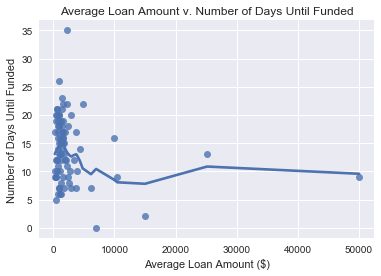

In [6]:
# Plot of average loan amount per country and amount of time to get funded:

sort_country = by_country2.sort_values('loan_amount', ascending = False)
sort_country['days_to_loan'] = sort_country['time_to_loan'].dt.days

sns.regplot(x = 'loan_amount', y = 'days_to_loan', data = sort_country, lowess = True).set(
title = 'Average Loan Amount v. Number of Days Until Funded', xlabel = 'Average Loan Amount ($)', 
ylabel = 'Number of Days Until Funded')
plt.show()

As you can see here, the outliers (i.e. loans totalling above $10,000 or so) make it difficult to see if there are any trends for the smaller loan amounts (given a quick glance at their variation, however, it seems unlikely that there exists a correlation).  Nonetheless, removing these outliers will help identify if any more subtle trends exist.

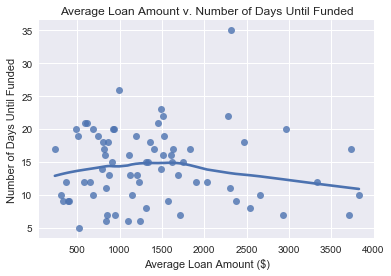

loan_amount                    845.906
time_to_loan    5 days 13:06:27.648563
days_to_loan                   5.52127
dtype: object


In [7]:
# Removing the outliers:

sort_country2 = sort_country.where(sort_country.loan_amount < 4000)

sns.regplot(x = 'loan_amount', y = 'days_to_loan', data = sort_country2, scatter = True, lowess = True).set(
title = 'Average Loan Amount v. Number of Days Until Funded', xlabel = 'Average Loan Amount ($)', 
ylabel = 'Number of Days Until Funded')
plt.show()

print(np.std(sort_country2, axis = 0))

Alas, even after adjusting for outliers, we can see that there is no correlation between an average loan amount and the length of time to get funding.  Running a standard deviation verifies this, since there is a fair amount of fluctuation between not only the loan amount, but the number of days it takes to receive funding (making any correlation if there were one, relatively weak). It does not seem as if these variables point to any trends for our hypothesis.  

And so we move on to our next variables (i.e. Sector, Loan Theme Type, etc), with a correlation chart first to see what else might be in store.

#### Correlation Maps:

Doing an initial correlation map below, we can see that there is a strong positive correlation between **'lender_count'** (i.e. the number of lenders contributing to the fully funded loan) and the amount of the loan.  (This would make sense as you would probably need to reach more lenders as the amount of a loan increases). 

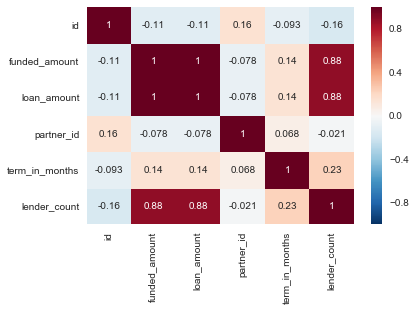

In [8]:
# Shows some possibilities - specifically with partner id and lender count
plt.show(sns.heatmap(loan_df.corr(), annot = True))

## Lender Count and Days to Funding:

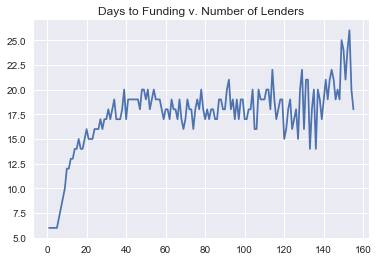

In [9]:
# Looking at lender count in more detail:

lender_info = loan_df.groupby('lender_count').agg({'lender_count': 'count',
                                     'loan_amount': 'mean',
                                     'term_in_months': 'mean'})
lender_time = loan_df.groupby('lender_count')['time_to_loan'].agg(lambda x: x.median())
lender_info['time_to_loan'] = lender_time.iloc[:]
lender_info['days_to_loan'] = (lender_time.iloc[:].dt.days)

#Splitting the lenders into group-counts:

lender_info1 = lender_info.iloc[0:155,]
lender_info2 = lender_info.iloc[156:311]
lender_info3 = lender_info.iloc[312:,]

# Then looking at their graphs:
plt.plot(lender_info1.days_to_loan)
plt.title('Days to Funding v. Number of Lenders')
plt.show()

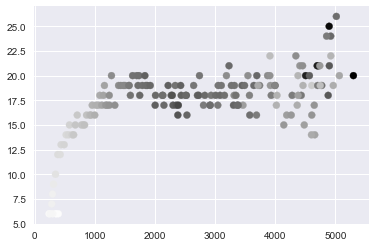

In [10]:
#sns.heatmap(lender_info.corr(), annot = True)

plt.scatter(x = 'loan_amount', y =  'days_to_loan', data = lender_info1, c = 'term_in_months')

plt.show()

Here, we can see that the number of days it takes to get a loan fully funded increases *considerably* between 0 and 20 lenders and begins to plateau (albeit quite variegated) after that; while the number of days ranges between 18 and 22, we do not see the 0 to 20 day jump you see within the first 20 values on the x-axis.  This shows us that the number of lenders can certainly be a contender for our hypothesis.

## Sectors and Days to Funding:

Below, the sectors to which the loans have gone are grouped and their average number of days to reach full-funding have been calculated. 

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


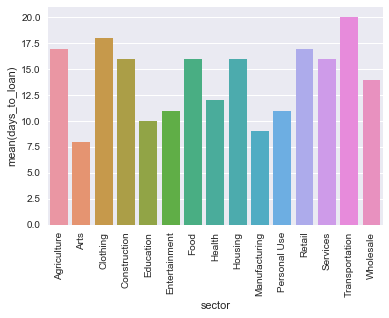

In [11]:
# Similar metrics grouped by Sector:
 
by_sector['days_to_loan'] = by_sector['time_to_loan'].dt.days

sns.barplot(x = by_sector.index, y = 'days_to_loan', data = by_sector).set_xticklabels(['Agriculture', 
        'Arts', 'Clothing', 'Construction', 'Education', 'Entertainment', 'Food', 'Health', 'Housing', 
        'Manufacturing','Personal Use', 'Retail', 'Services', 'Transportation', 'Wholesale'], rotation = 90)
plt.show()

## Partner ID and Days to Funding

Here, comparing the two graphs of the most and least lending partners, you can see that the partners that lend more frequently tend to have a more consistent time-frame and less variation in the number of days they take to get a loan fully funded.  As a result, this could be an interesting secondary metric to keep an eye on and look into further.

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


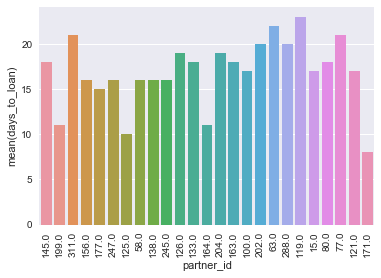

In [12]:
# Similar metrics grouped by Partner ID:

partner_count = partners.nlargest(25, 'id')
partner_count['days_to_loan'] = partner_time[:].dt.days
partner_count = partner_count[['id', 'loan_amount', 'lender_count', 'time_to_loan', 'days_to_loan']]
partner_count = partner_count[['id', 'loan_amount', 'lender_count', 'time_to_loan', 'days_to_loan']]

sns.barplot(x = partner_count.index, y = 'days_to_loan', data = partner_count).set_xticklabels([145.0, 199.0, 
                311.0, 156.0, 177.0, 247.0, 125.0,  58.0, 138.0, 245.0, 126.0, 133.0, 164.0, 204.0, 163.0, 
                100.0, 202.0,  63.0, 288.0, 119.0,  15.0,  80.0,  77.0, 121.0, 171.0], rotation = 90)
plt.show()

/anaconda/lib/python3.6/site-packages/seaborn/categorical.py:1428: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


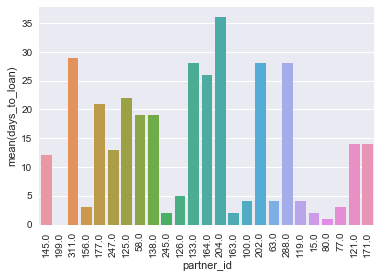

In [13]:
partner_count = partners.nsmallest(25, 'id')
partner_count['days_to_loan'] = partner_time[:].dt.days
partner_count = partner_count[['id', 'loan_amount', 'lender_count', 'time_to_loan', 'days_to_loan']]
partner_count = partner_count[['id', 'loan_amount', 'lender_count', 'time_to_loan', 'days_to_loan']]

sns.barplot(x = partner_count.index, y = 'days_to_loan', data = partner_count).set_xticklabels([145.0, 199.0, 
                311.0, 156.0, 177.0, 247.0, 125.0,  58.0, 138.0, 245.0, 126.0, 133.0, 164.0, 204.0, 163.0, 
                100.0, 202.0,  63.0, 288.0, 119.0,  15.0,  80.0,  77.0, 121.0, 171.0], rotation = 90)
plt.show()

##  Rollout Plan and Evaluation:

Based on our analysis thus far, the number of lenders seems like the most crucial variable towards getting a loan fully funded in the quickest amount of time. In order to study this further, you would want to design a study with the following aspects in its design:

- Continue to monitor the length of time between which a loan is posted and when it is fully-funded and, 
- Monitor the number of lenders who contribute to each loan.

Further questions you would want to consider might be, does the amount of the loan change these time-frames at all
and are there certain partners who are more effective at getting these loans funded more quickly.

Continuing to monitor partner id counts, sector counts and average amounts of each loan would help you measure these aspects. 

In order to evaluate the end results, you would want to look for a consistent number of days towards funding for the number of lenders you have (i.e. 0-10 lenders would take 0-10 days).


